<a href="https://colab.research.google.com/github/LUMII-AILab/NLP_Course/blob/main/notebooks/Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2vec modeļa izveide
# Building and using Word2vec model

## Pre-processing


Teksta lejuplāde un sadalīšana rindiņās

Preprocessing - download and line segmentation

In [ ]:
!pip install --upgrade gensim
import os
os.kill(os.getpid(), 9)

import urllib
import re
import multiprocessing
from time import time
from gensim.models import Word2Vec


# change to your own path if you have downloaded the file locally
url = 'https://raw.githubusercontent.com/alexisperrier/intro2nlp/master/data/Shakespeare_alllines.txt'
#url = "https://repository.clarin.lv/repository/xmlui/bitstream/handle/20.500.12574/41/rainis_v20180716.txt?sequence=1&isAllowed=y"
# read file into list of lines
lines = urllib.request.urlopen(url).read().decode('utf-8').split("\n")

Teksta priekšapstrāde - sadalīšana tekstvienībās

Tokenization





In [ ]:
sentences = []

for line in lines:
   # remove punctuation
   line = re.sub(r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]','',line).strip()
#   line = line.lower()

   # simple tokenizer
   tokens = re.findall(r'\b\w+\b', line)

   # only keep lines with at least one token
   if len(tokens) > 1:
      sentences.append(tokens)

## Training




Modeļa apmācība

Training

The parameters:

*   min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
*   window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)



In [ ]:

w2v_model = Word2Vec(
         sentences,
         min_count=3,   # Ignore words that appear less than this
         vector_size=50,       # Dimensionality of word embeddings
         sg = 1,        # skipgrams
         window=7,      # Context window for words during training
         epochs=40)       # Number of epochs training over corpus

Alternatīva: apmacība pa soļiem

Training in several steps (alternative)

In [ ]:
import multiprocessing


cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=50,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)


t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(7977551, 24900450)

##Modelis darbībā

##Application

In [ ]:
#w2v_model.wv.most_similar('mīla')
w2v_model.wv.most_similar('Romeo')

[('Tybalt', 0.782357931137085),
 ('banished', 0.6882820725440979),
 ('dead', 0.6670898199081421),
 ('Montague', 0.6135813593864441),
 ('slew', 0.6093910932540894),
 ('likeness', 0.5784539580345154),
 ('murderer', 0.5732345581054688),
 ('slain', 0.5714975595474243),
 ('alive', 0.555724561214447),
 ('Revenge', 0.5550365447998047)]

In [ ]:
# w2v_model.wv.most_similar(positive=["saule"])

In [ ]:
# w2v_model.wv.most_similar(negative=["saule"])
w2v_model.wv.most_similar(negative=["Romeo"])

[('outward', 0.33558687567710876),
 ('particular', 0.32263290882110596),
 ('several', 0.31608662009239197),
 ('solemn', 0.31299105286598206),
 ('bent', 0.3088178336620331),
 ('According', 0.27967268228530884),
 ('gives', 0.2794358730316162),
 ('strong', 0.2735427916049957),
 ('In', 0.2719707190990448),
 ('offices', 0.26147621870040894)]

In [ ]:
# w2v_model.wv.similarity("saule", "pavasars")
w2v_model.wv.similarity("Juliet", "Romeo")

0.543802

In [ ]:
# w2v_model.wv.doesnt_match(["brīve", "pavasars", "saule"])
w2v_model.wv.doesnt_match(["Juliet", "battle", "Romeo"])

'battle'

Citi nopietnāki un mazāk nopietni materiāli:

* Tensorflow Word2Vec Tutorial:https://www.tensorflow.org/text/tutorials/word2vec
* Gensim Word2Vec Tutorial: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook#Getting-Started




## Vārdu līdzības vizualizācija
## Visualisation
Vizualizācijai pielietojam MatPlotLib un SeaBorn bibliotēkas. <br>
Sklearn bibliotēka pielieto PCA un TSNE metodes, kas pārveido vārdus vektoru formā (skatīt vector_size pie word2vec), par punktu 2D telpā. <br>
Šīs dimensiju redukcijas metodes pēc iespējas saglabā individuālo vārdu līdzības.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 50), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 50 to 21 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-np.absolute(Y[:, 0].min())*0.2, Y[:, 0].max()+np.absolute(Y[:, 0].max())*0.2)
    plt.ylim(Y[:, 1].min()-np.absolute(Y[:, 1].min())*0.2, Y[:, 1].max()+np.absolute(Y[:, 1].max())*0.2)

    plt.title('t-SNE visualization for {}'.format(word.title()))

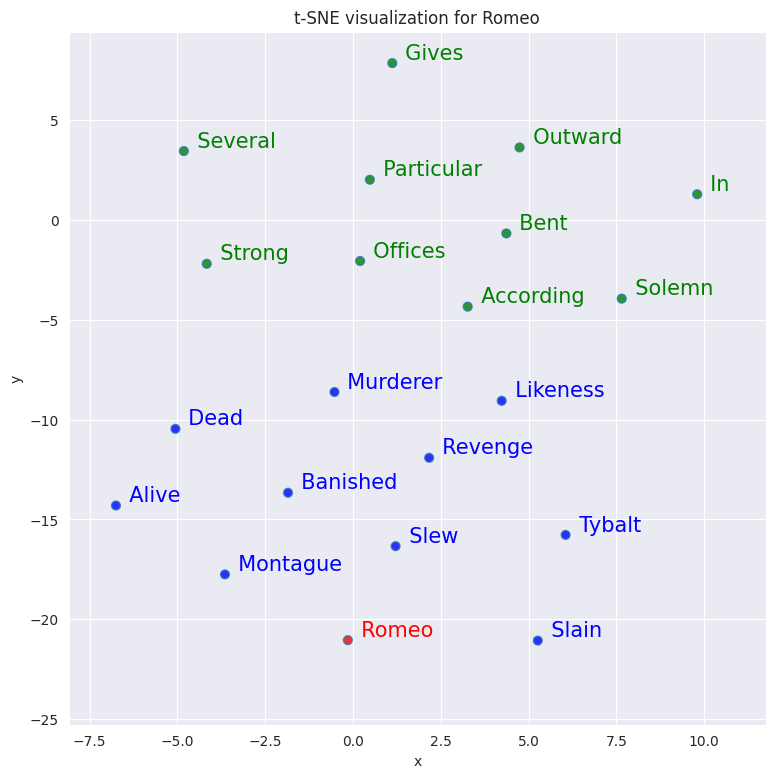

In [ ]:
# Red: Original word
# Blue: 10 closest word matches to the original word
# Green: 10 furthest word matches to the original word

word = "Romeo"
tsnescatterplot(w2v_model, word, [i[0] for i in w2v_model.wv.most_similar(negative=[word])])